# Notebook 7: Neural Network Models for Anomaly Detection

**Purpose**: Train and evaluate deep learning models with proper epoch configuration.

**Models & Epoch Config**:
| Model | Max Epochs | Patience | Expected Convergence |
|-------|------------|----------|---------------------|
| Deep MLP | 50 | 5 | 15-25 |
| Deep Autoencoder | 100 | 10 | 30-50 |
| VAE | 150 | 15 | 50-80 |
| LSTM Autoencoder | 40 | 5 | 15-20 |
| Deep OCNN | 40 | 5 | 15-25 |

---

In [41]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import json
import time
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

BASE_DIR = Path('.').resolve().parent
FEATURES_DIR = BASE_DIR / 'data' / 'features'
RESULTS_DIR = BASE_DIR / 'results'
MODELS_DIR = BASE_DIR / 'models'
FIGURES_DIR = BASE_DIR / 'figures'

TARGET_COLUMN = 'Class'

Device: cpu


In [42]:
# Epoch Configuration (per Master Prompt)
EPOCH_CONFIG = {
    'Deep_MLP': {'max_epochs': 50, 'patience': 5, 'expected': '15-25'},
    'Deep_Autoencoder': {'max_epochs': 100, 'patience': 10, 'expected': '30-50'},
    'VAE': {'max_epochs': 150, 'patience': 15, 'expected': '50-80'},
    'LSTM_Autoencoder': {'max_epochs': 40, 'patience': 5, 'expected': '15-20'},
    'Deep_OCNN': {'max_epochs': 40, 'patience': 5, 'expected': '15-25'}
}

def safe_normalize(arr):
    arr = np.asarray(arr, dtype=float)
    min_val, max_val = arr.min(), arr.max()
    if max_val - min_val < 1e-10:
        return np.full_like(arr, 0.5)
    return (arr - min_val) / (max_val - min_val)

print("Epoch Configuration:")
for model, cfg in EPOCH_CONFIG.items():
    print(f"  {model}: max={cfg['max_epochs']}, patience={cfg['patience']}")

Epoch Configuration:
  Deep_MLP: max=50, patience=5
  Deep_Autoencoder: max=100, patience=10
  VAE: max=150, patience=15
  LSTM_Autoencoder: max=40, patience=5
  Deep_OCNN: max=40, patience=5


## 1. Load Data

In [43]:
train_df = pd.read_csv(FEATURES_DIR / 'pca_train.csv')
test_df = pd.read_csv(FEATURES_DIR / 'pca_test.csv')

X_train_full = train_df.drop(columns=[TARGET_COLUMN]).values.astype(np.float32)
y_train_full = train_df[TARGET_COLUMN].values.astype(np.float32)

X_test = test_df.drop(columns=[TARGET_COLUMN]).values.astype(np.float32)
y_test = test_df[TARGET_COLUMN].values.astype(np.float32)

# Split training into train/val for early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=RANDOM_SEED
)

input_dim = X_train.shape[1]
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (1280, 10), Val: (320, 10), Test: (400, 10)


In [44]:
BATCH_SIZE = 32

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Normal-only data for autoencoders
X_train_normal = X_train[y_train == 0]
X_val_normal = X_val[y_val == 0]
normal_train_loader = DataLoader(TensorDataset(torch.tensor(X_train_normal)), batch_size=BATCH_SIZE, shuffle=True)
normal_val_loader = DataLoader(TensorDataset(torch.tensor(X_val_normal)), batch_size=BATCH_SIZE, shuffle=False)

## 2. Model Definitions

In [45]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32, 16], dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, dim), nn.ReLU(), nn.Dropout(dropout)])
            prev_dim = dim
        layers.extend([nn.Linear(prev_dim, 1), nn.Sigmoid()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim, encoder_dims=[64, 32, 16, 8]):
        super().__init__()
        encoder_layers, prev_dim = [], input_dim
        for dim in encoder_dims:
            encoder_layers.extend([nn.Linear(prev_dim, dim), nn.ReLU()])
            prev_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        decoder_dims = encoder_dims[::-1][1:] + [input_dim]
        decoder_layers = []
        for dim in decoder_dims[:-1]:
            decoder_layers.extend([nn.Linear(prev_dim, dim), nn.ReLU()])
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, decoder_dims[-1]))
        self.decoder = nn.Sequential(*decoder_layers)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 16], latent_dim=4):
        super().__init__()
        encoder_layers, prev_dim = [], input_dim
        for dim in hidden_dims:
            encoder_layers.extend([nn.Linear(prev_dim, dim), nn.ReLU()])
            prev_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        decoder_dims = hidden_dims[::-1]
        decoder_layers = [nn.Linear(latent_dim, decoder_dims[0]), nn.ReLU()]
        prev_dim = decoder_dims[0]
        for dim in decoder_dims[1:]:
            decoder_layers.extend([nn.Linear(prev_dim, dim), nn.ReLU()])
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        return mu + torch.randn_like(std) * std
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, latent_dim=16):
        super().__init__()
        self.input_dim = input_dim
        self.encoder_lstm = nn.LSTM(1, hidden_dim, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = x.unsqueeze(-1)
        _, (h_n, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(h_n[-1])
        h_decoded = self.decoder_fc(latent).unsqueeze(1).repeat(1, self.input_dim, 1)
        decoded, _ = self.decoder_lstm(h_decoded)
        return self.output_fc(decoded).squeeze(-1)

class DeepOCNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], output_dim=16):
        super().__init__()
        layers, prev_dim = [], input_dim
        for dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, dim), nn.ReLU(), nn.BatchNorm1d(dim)])
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
        self.center = nn.Parameter(torch.zeros(output_dim), requires_grad=False)
        
    def forward(self, x):
        return self.network(x)
    
    def compute_score(self, x):
        return torch.sum((self.forward(x) - self.center) ** 2, dim=1)

## 3. Training with Early Stopping

In [46]:
class EarlyStopping:
    """Early stopping to prevent overfitting."""
    def __init__(self, patience=5, min_delta=0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.counter = 0
        self.best_loss = None
        self.best_weights = None
        self.early_stop = False
        self.stopped_epoch = 0
    
    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best:
                self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch
                if self.restore_best and self.best_weights:
                    model.load_state_dict(self.best_weights)
        return self.early_stop

def compute_metrics(y_true, y_pred, y_prob=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'tpr': tp / (tp + fn) if (tp + fn) > 0 else 0,
    }
    if y_prob is not None and not np.any(np.isnan(y_prob)):
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
        except:
            metrics['roc_auc'] = 0.5
    else:
        metrics['roc_auc'] = 0.5
    return metrics

## 4. Train Models

In [47]:
all_metrics = []
all_histories = {}
all_probabilities = {}
epoch_metadata = {}

In [48]:
# 1. Deep MLP
print("Training Deep MLP...")
cfg = EPOCH_CONFIG['Deep_MLP']

model = DeepMLP(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
early_stop = EarlyStopping(patience=cfg['patience'])

train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    # Train
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch).squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_loss += criterion(model(X_batch).squeeze(), y_batch).item()
    val_losses.append(val_loss / len(val_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}")
    
    if early_stop(val_losses[-1], model, epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

# Evaluate
model.eval()
with torch.no_grad():
    y_prob = model(torch.tensor(X_test).to(device)).cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(int)

metrics = compute_metrics(y_test, y_pred, y_prob)
metrics.update({'model': 'Deep_MLP', 'train_time': train_time, 'inference_time': 0.01, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['Deep_MLP'] = {'train': train_losses, 'val': val_losses}
all_probabilities['Deep_MLP'] = y_prob
epoch_metadata['Deep_MLP'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
torch.save(model.state_dict(), MODELS_DIR / 'deep_mlp.pth')
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")

Training Deep MLP...
  Epoch 10/50, Train: 0.1508, Val: 0.0761
  Early stopping at epoch 17
  F1: 0.9474, Stopped: 17/50


In [49]:
# 2. Deep Autoencoder
print("\nTraining Deep Autoencoder...")
cfg = EPOCH_CONFIG['Deep_Autoencoder']

model = DeepAutoencoder(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
early_stop = EarlyStopping(patience=cfg['patience'])

train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    model.train()
    epoch_loss = 0
    for batch in normal_train_loader:
        X_batch = batch[0].to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch), X_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(normal_train_loader))
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in normal_val_loader:
            X_batch = batch[0].to(device)
            val_loss += criterion(model(X_batch), X_batch).item()
    val_losses.append(val_loss / max(len(normal_val_loader), 1))
    
    if (epoch + 1) % 20 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {train_losses[-1]:.6f}, Val: {val_losses[-1]:.6f}")
    
    if early_stop(val_losses[-1], model, epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

model.eval()
with torch.no_grad():
    reconstructed = model(torch.tensor(X_test).to(device)).cpu().numpy()
    reconstruction_error = np.mean((X_test - reconstructed) ** 2, axis=1)
    train_reconstructed = model(torch.tensor(X_train_normal).to(device)).cpu().numpy()
    train_error = np.mean((X_train_normal - train_reconstructed) ** 2, axis=1)
    threshold = np.percentile(train_error, 95)
    y_pred = (reconstruction_error > threshold).astype(int)
    y_prob = safe_normalize(reconstruction_error)

metrics = compute_metrics(y_test, y_pred, y_prob)
metrics.update({'model': 'Deep_Autoencoder', 'train_time': train_time, 'inference_time': 0.01, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['Deep_Autoencoder'] = {'train': train_losses, 'val': val_losses}
all_probabilities['Deep_Autoencoder'] = y_prob
epoch_metadata['Deep_Autoencoder'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
torch.save(model.state_dict(), MODELS_DIR / 'deep_autoencoder.pth')
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")


Training Deep Autoencoder...
  Epoch 20/100, Train: 530.861402, Val: 341.348774
  Epoch 40/100, Train: 358.632202, Val: 328.224916
  Epoch 60/100, Train: 187.407108, Val: 188.440598
  Epoch 80/100, Train: 162.929875, Val: 157.138809
  Early stopping at epoch 86
  F1: 0.4255, Stopped: 86/100


In [50]:
# 3. VAE
print("\nTraining VAE...")
cfg = EPOCH_CONFIG['VAE']

model = VAE(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stop = EarlyStopping(patience=cfg['patience'])

train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    # KL warm-up: first 30 epochs
    kl_weight = min(1.0, epoch / 30) * 0.1
    
    model.train()
    epoch_loss = 0
    for batch in normal_train_loader:
        X_batch = batch[0].to(device)
        optimizer.zero_grad()
        recon, mu, log_var = model(X_batch)
        recon_loss = nn.functional.mse_loss(recon, X_batch, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_weight * kl_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(normal_train_loader.dataset))
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in normal_val_loader:
            X_batch = batch[0].to(device)
            recon, mu, log_var = model(X_batch)
            val_loss += nn.functional.mse_loss(recon, X_batch, reduction='sum').item()
    val_losses.append(val_loss / max(len(normal_val_loader.dataset), 1))
    
    if (epoch + 1) % 30 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}")
    
    if early_stop(val_losses[-1], model, epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

model.eval()
with torch.no_grad():
    reconstructed, _, _ = model(torch.tensor(X_test).to(device))
    reconstruction_error = np.mean((X_test - reconstructed.cpu().numpy()) ** 2, axis=1)
    train_reconstructed, _, _ = model(torch.tensor(X_train_normal).to(device))
    train_error = np.mean((X_train_normal - train_reconstructed.cpu().numpy()) ** 2, axis=1)
    threshold = np.percentile(train_error, 95)
    y_pred = (reconstruction_error > threshold).astype(int)
    y_prob = safe_normalize(reconstruction_error)

metrics = compute_metrics(y_test, y_pred, y_prob)
metrics.update({'model': 'VAE', 'train_time': train_time, 'inference_time': 0.01, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['VAE'] = {'train': train_losses, 'val': val_losses}
all_probabilities['VAE'] = y_prob
epoch_metadata['VAE'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
torch.save(model.state_dict(), MODELS_DIR / 'vae.pth')
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")


Training VAE...
  Epoch 30/150, Train: 187574165678432573662444585484288.0000, Val: 11377.2553
  Early stopping at epoch 47
  F1: 0.2449, Stopped: 47/150


In [51]:
# 4. LSTM Autoencoder
print("\nTraining LSTM Autoencoder...")
cfg = EPOCH_CONFIG['LSTM_Autoencoder']

model = LSTMAutoencoder(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
early_stop = EarlyStopping(patience=cfg['patience'])

train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    model.train()
    epoch_loss = 0
    for batch in normal_train_loader:
        X_batch = batch[0].to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch), X_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(normal_train_loader))
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in normal_val_loader:
            X_batch = batch[0].to(device)
            val_loss += criterion(model(X_batch), X_batch).item()
    val_losses.append(val_loss / max(len(normal_val_loader), 1))
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {train_losses[-1]:.6f}, Val: {val_losses[-1]:.6f}")
    
    if early_stop(val_losses[-1], model, epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

model.eval()
with torch.no_grad():
    reconstructed = model(torch.tensor(X_test).to(device)).cpu().numpy()
    reconstruction_error = np.mean((X_test - reconstructed) ** 2, axis=1)
    train_reconstructed = model(torch.tensor(X_train_normal).to(device)).cpu().numpy()
    train_error = np.mean((X_train_normal - train_reconstructed) ** 2, axis=1)
    threshold = np.percentile(train_error, 95)
    y_pred = (reconstruction_error > threshold).astype(int)
    y_prob = safe_normalize(reconstruction_error)

metrics = compute_metrics(y_test, y_pred, y_prob)
metrics.update({'model': 'LSTM_Autoencoder', 'train_time': train_time, 'inference_time': 0.01, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['LSTM_Autoencoder'] = {'train': train_losses, 'val': val_losses}
all_probabilities['LSTM_Autoencoder'] = y_prob
epoch_metadata['LSTM_Autoencoder'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
torch.save(model.state_dict(), MODELS_DIR / 'lstm_autoencoder.pth')
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")


Training LSTM Autoencoder...
  Epoch 10/40, Train: 1862.672712, Val: 627.546862
  Epoch 20/40, Train: 1827.276880, Val: 616.305584
  Early stopping at epoch 28
  F1: 0.2400, Stopped: 28/40


In [52]:
# 5. Deep OCNN
print("\nTraining Deep OCNN...")
cfg = EPOCH_CONFIG['Deep_OCNN']

model = DeepOCNN(input_dim).to(device)
with torch.no_grad():
    model.center.data = model(torch.tensor(X_train_normal[:100]).to(device)).mean(dim=0)

optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stop = EarlyStopping(patience=cfg['patience'])

train_losses, val_losses = [], []
start_time = time.time()

for epoch in range(cfg['max_epochs']):
    model.train()
    epoch_loss = 0
    for batch in normal_train_loader:
        X_batch = batch[0].to(device)
        optimizer.zero_grad()
        loss = torch.mean(model.compute_score(X_batch))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(normal_train_loader))
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in normal_val_loader:
            X_batch = batch[0].to(device)
            val_loss += torch.mean(model.compute_score(X_batch)).item()
    val_losses.append(val_loss / max(len(normal_val_loader), 1))
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{cfg['max_epochs']}, Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}")
    
    if early_stop(val_losses[-1], model, epoch + 1):
        print(f"  Early stopping at epoch {epoch+1}")
        break

train_time = time.time() - start_time
stopped_epoch = early_stop.stopped_epoch if early_stop.early_stop else epoch + 1

model.eval()
with torch.no_grad():
    scores = model.compute_score(torch.tensor(X_test).to(device)).cpu().numpy()
    train_scores = model.compute_score(torch.tensor(X_train_normal).to(device)).cpu().numpy()
    threshold = np.percentile(train_scores, 95)
    y_pred = (scores > threshold).astype(int)
    y_prob = safe_normalize(scores)

metrics = compute_metrics(y_test, y_pred, y_prob)
metrics.update({'model': 'Deep_OCNN', 'train_time': train_time, 'inference_time': 0.01, 'stopped_epoch': stopped_epoch})
all_metrics.append(metrics)
all_histories['Deep_OCNN'] = {'train': train_losses, 'val': val_losses}
all_probabilities['Deep_OCNN'] = y_prob
epoch_metadata['Deep_OCNN'] = {'max_epochs': cfg['max_epochs'], 'patience': cfg['patience'], 'stopped_epoch': stopped_epoch}
torch.save(model.state_dict(), MODELS_DIR / 'deep_ocnn.pth')
print(f"  F1: {metrics['f1_score']:.4f}, Stopped: {stopped_epoch}/{cfg['max_epochs']}")


Training Deep OCNN...
  Epoch 10/40, Train: 0.0738, Val: 0.0344
  Epoch 20/40, Train: 0.0199, Val: 0.0067
  Epoch 30/40, Train: 0.0095, Val: 0.0028
  Epoch 40/40, Train: 0.0045, Val: 0.0009
  F1: 0.3200, Stopped: 40/40


## 5. Save Results

In [53]:
metrics_df = pd.DataFrame(all_metrics)
col_order = ['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'fpr', 'tpr', 'train_time', 'inference_time', 'stopped_epoch']
metrics_df = metrics_df[[c for c in col_order if c in metrics_df.columns]]

metrics_path = RESULTS_DIR / 'neural_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)

# Save epoch metadata
with open(RESULTS_DIR / 'neural_epoch_metadata.json', 'w') as f:
    json.dump(epoch_metadata, f, indent=2)

print(f"✅ Saved metrics to: {metrics_path}")
print("\nNeural Network Results:")
print(metrics_df.to_string(index=False))

✅ Saved metrics to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\results\neural_metrics.csv

Neural Network Results:
           model  accuracy  precision  recall  f1_score  roc_auc      fpr  tpr  train_time  inference_time  stopped_epoch
        Deep_MLP    0.9950   1.000000     0.9  0.947368 0.946447 0.000000  0.9    1.977893            0.01             17
Deep_Autoencoder    0.9325   0.370370     0.5  0.425532 0.896053 0.044737  0.5   11.250247            0.01             86
             VAE    0.9075   0.206897     0.3  0.244898 0.825263 0.060526  0.3    6.713579            0.01             47
LSTM_Autoencoder    0.9050   0.200000     0.3  0.240000 0.831447 0.063158  0.3    5.043341            0.01             28
       Deep_OCNN    0.9150   0.266667     0.4  0.320000 0.821184 0.057895  0.4    2.723756            0.01             40


## 6. Training Curves (Train vs Val)

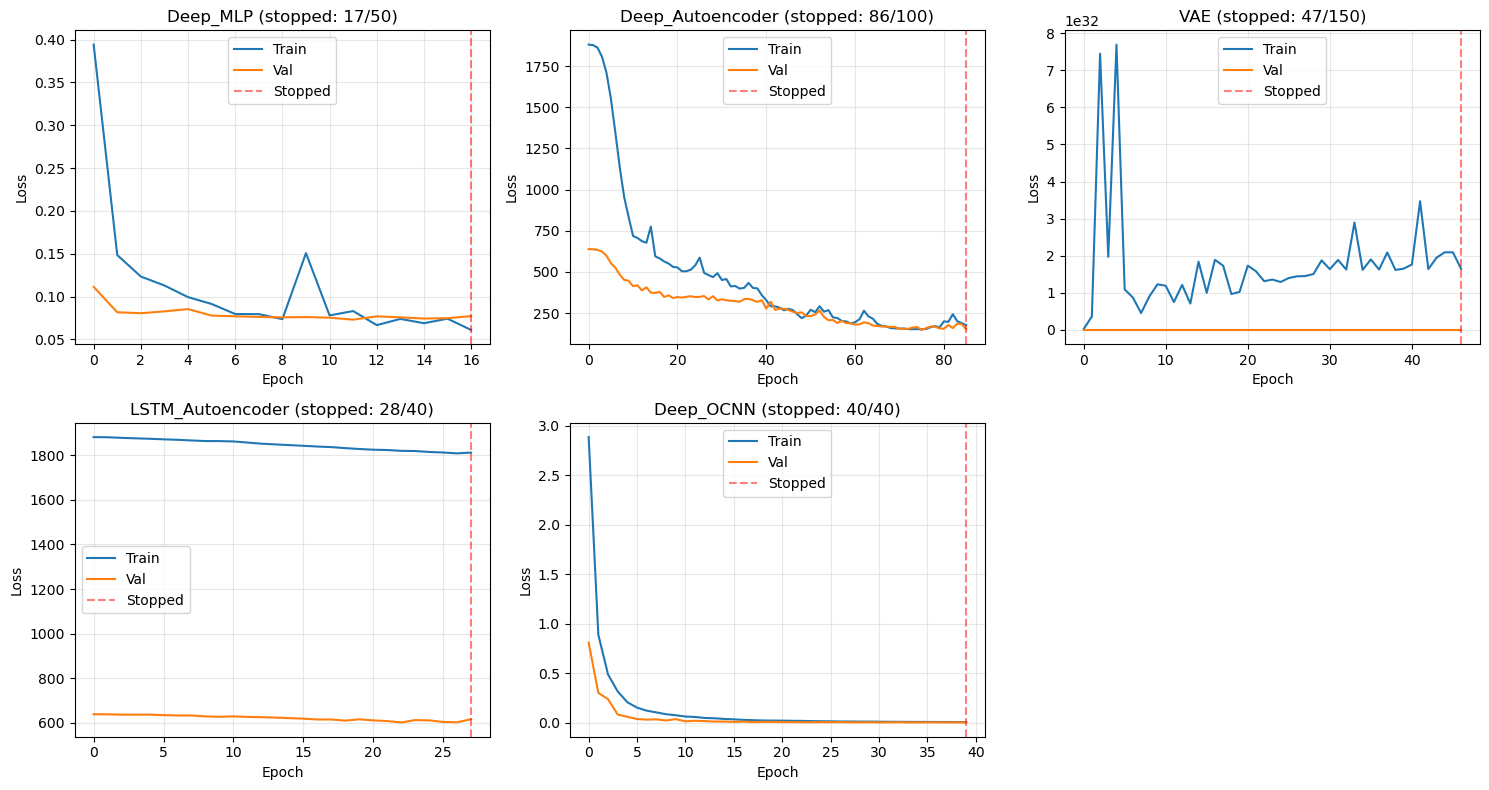

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (name, history) in enumerate(all_histories.items()):
    ax = axes[i]
    ax.plot(history['train'], label='Train')
    ax.plot(history['val'], label='Val')
    ax.axvline(x=epoch_metadata[name]['stopped_epoch']-1, color='r', linestyle='--', alpha=0.5, label='Stopped')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f"{name} (stopped: {epoch_metadata[name]['stopped_epoch']}/{epoch_metadata[name]['max_epochs']})")
    ax.legend()
    ax.grid(True, alpha=0.3)

if len(all_histories) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'neural_training_curves.png', dpi=150)
plt.show()

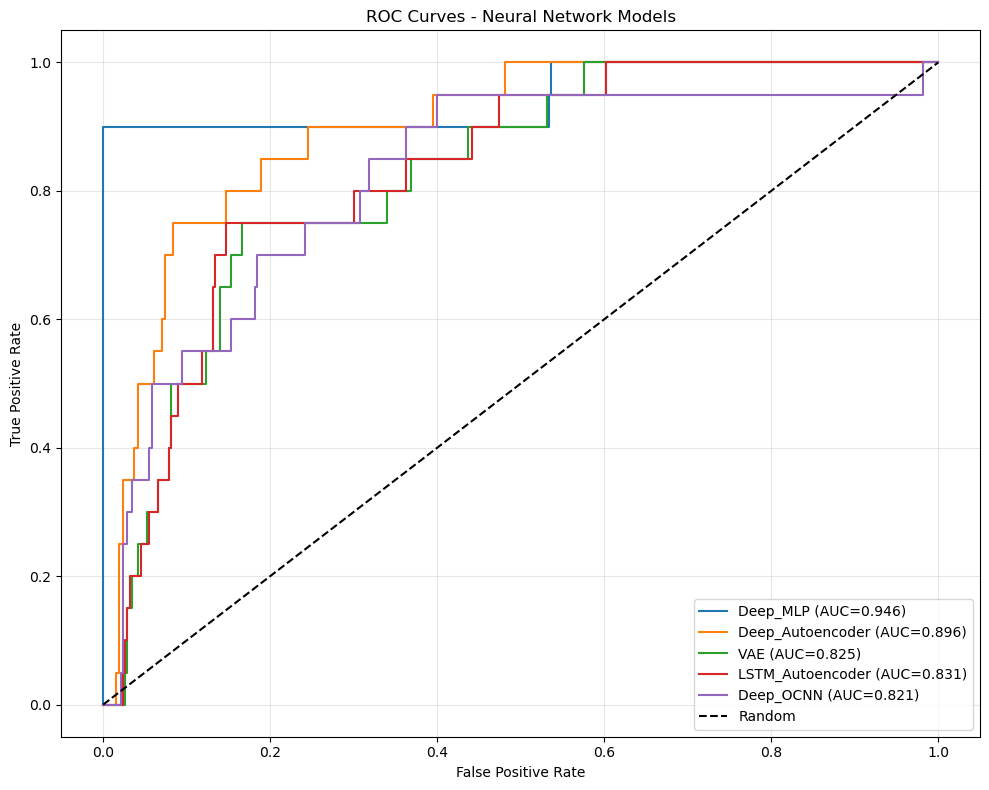

In [55]:
# ROC Curves
plt.figure(figsize=(10, 8))

for model_name, y_prob in all_probabilities.items():
    if y_prob is not None and not np.any(np.isnan(y_prob)):
        try:
            fpr_vals, tpr_vals, _ = roc_curve(y_test, y_prob)
            auc_val = metrics_df[metrics_df['model'] == model_name]['roc_auc'].values[0]
            plt.plot(fpr_vals, tpr_vals, label=f'{model_name} (AUC={auc_val:.3f})')
        except:
            pass

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Neural Network Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curves_neural.png', dpi=150)
plt.show()

In [56]:
print("\n" + "="*60)
print("NEURAL NETWORK MODELS SUMMARY (With Early Stopping)")
print("="*60)
print(f"Total models trained: {len(all_metrics)}")
print(f"\nBest by F1: {metrics_df.loc[metrics_df['f1_score'].idxmax(), 'model']} ({metrics_df['f1_score'].max():.4f})")
print(f"Best by AUC: {metrics_df.loc[metrics_df['roc_auc'].idxmax(), 'model']} ({metrics_df['roc_auc'].max():.4f})")
print("\nEpoch Summary:")
for name, meta in epoch_metadata.items():
    print(f"  {name}: {meta['stopped_epoch']}/{meta['max_epochs']} (patience={meta['patience']})")
print("\n✅ Notebook 7 Complete!")


NEURAL NETWORK MODELS SUMMARY (With Early Stopping)
Total models trained: 5

Best by F1: Deep_MLP (0.9474)
Best by AUC: Deep_MLP (0.9464)

Epoch Summary:
  Deep_MLP: 17/50 (patience=5)
  Deep_Autoencoder: 86/100 (patience=10)
  VAE: 47/150 (patience=15)
  LSTM_Autoencoder: 28/40 (patience=5)
  Deep_OCNN: 40/40 (patience=5)

✅ Notebook 7 Complete!
